# Churn prediction for an energy company 🔌💡
## Part 3 - Model Building
### Importing packages and models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# SAS models
from sasviya.ml.linear_model import LogisticRegression as SASLogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier as SASDecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as SASForestClassifier
from sasviya.ml.tree import GradientBoostingClassifier as SASGradientBoostingClassifier

# scikit-learn classes and models
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SKGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

from model_building_utils import *

target = 'churn'
repo_path = '/workspaces/myfolder/energy-churn-prediction'

### Model Building for non-transformed dataset

In [2]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")
merged_df.head(5)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,price_peak_fix_std,price_mid_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_mid_peak_var_max_diff,price_off_peak_fix_max_diff,price_peak_fix_max_diff,price_mid_peak_fix_max_diff,product_modified,days_to_end
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,0.00,0,0.0,1.78,0.114481,...,7.039226,4.692817,0.028554,0.000568,0.002337,3.538045,0.097752,0.065172,Yes,167
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,0.000000,0.001567,0.085483,0.000000,0.177780,0.000000,0.000000,No,243
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,0.000000,0.000000,0.001281,0.000000,0.177779,0.000000,0.000000,No,107
3,bba03439a292a1e166f80264c16191cb,Channel 2,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.177779,0.000000,0.000000,No,90
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.044209,0.029473,0.001969,0.001867,0.003541,0.162916,0.097749,0.065166,No,67


In [3]:
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13131 (90.38 %)
- Number of rows with churn='Yes': 1398 (9.62 %)


In [4]:
sas_lr = SASLogisticRegression()
sklearn_lr = SKLogisticRegression(solver='liblinear')

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

# Define the pipeline
sklearn_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_lr)
])

One way to evaluate the quality of a probability estimate is by examining the ranking it produces. A good probability estimate should rank all the minority class observations (e.g., churners) and then those from the majority class (e.g., non-churners). In other words, it should assign high probabilities to positive examples and low probabilities to negative ones. A widely used ranking measure for imbalanced datasets is **AUC (Area Under the ROC Curve)**. If a threshold exists that perfectly separates churners from non-churners, the AUC will be 1.
Since our goal is to create a reliable **scoring list** for a retention campaign targeting potential churners, we prioritize ranking quality over overall predictive accuracy. Therefore, we will use AUC as the evaluation metric to select the best-performing model.
Finally, since our main objective is to assess how well the model ranks customers, we can compare models with different prior distributions without adjusting the posterior probabilities, as the bias due to undersampling does not affect the ranking order returned by the posterior probability.

For more information, check out [this article](https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf).

In [5]:
k = 3
sampling_strategy = 0.2

sas_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sas_lr, 'Logistic Regression', 'SAS', k=k, sampling_strategy=sampling_strategy, numeric_cols=numeric_cols, nominals=cat_cols)
sklearn_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sklearn_lr_pipeline, 'Logistic Regression', 'scikit-learn', k=k, sampling_strategy=sampling_strategy, numeric_cols=numeric_cols)

metrics_df = sklearn_lr_model_metrics
metrics_df = pd.concat([metrics_df, sas_lr_model_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.680,0.650,0.001,0.004
1,Logistic Regression,SAS,0.686,0.649,0.003,0.007


In [6]:
sas_dtree = SASDecisionTreeClassifier()
sklearn_dtree = SKDecisionTreeClassifier()

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_dtree)
])

In [7]:
sklearn_dtree_metrics = train_and_evaluate_model(X_train, y_train, dtree_pipeline, 'Decision Tree', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
sas_dtree_metrics = train_and_evaluate_model(X_train, y_train, sas_dtree, 'Decision Tree', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_dtree_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_dtree_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.680,0.650,0.001,0.004
1,Logistic Regression,SAS,0.686,0.649,0.003,0.007
2,Decision Tree,scikit-learn,1.000,0.568,0.000,0.009
3,Decision Tree,SAS,0.596,0.553,0.037,0.027


In [8]:
# SAS Random Forest Model
sas_rf = SASForestClassifier()
sklearn_rf = SKRandomForestClassifier()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_rf)
])

In [9]:
sklearn_rf_metrics = train_and_evaluate_model(X_train, y_train, rf_pipeline, 'Random Forest', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
sas_rf_metrics = train_and_evaluate_model(X_train, y_train, sas_rf, 'Random Forest', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_rf_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_rf_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.680,0.650,0.001,0.004
1,Logistic Regression,SAS,0.686,0.649,0.003,0.007
2,Decision Tree,scikit-learn,1.000,0.568,0.000,0.009
3,Decision Tree,SAS,0.596,0.553,0.037,0.027
4,Random Forest,scikit-learn,1.000,0.675,0.000,0.004
5,Random Forest,SAS,0.782,0.632,0.014,0.006


In [10]:
sas_gb = SASGradientBoostingClassifier()
sklearn_gb = SKGradientBoostingClassifier()

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_gb)
])

In [11]:
sklearn_gb_metrics = train_and_evaluate_model(X_train, y_train, gb_pipeline, 'Gradient Boosting', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
sas_gb_metrics = train_and_evaluate_model(X_train, y_train, sas_gb, 'Gradient Boosting', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_gb_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_gb_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.680,0.650,0.001,0.004
1,Logistic Regression,SAS,0.686,0.649,0.003,0.007
2,Decision Tree,scikit-learn,1.000,0.568,0.000,0.009
3,Decision Tree,SAS,0.596,0.553,0.037,0.027
4,Random Forest,scikit-learn,1.000,0.675,0.000,0.004
5,Random Forest,SAS,0.782,0.632,0.014,0.006
6,Gradient Boosting,scikit-learn,0.842,0.678,0.005,0.014
7,Gradient Boosting,SAS,0.904,0.672,0.001,0.007


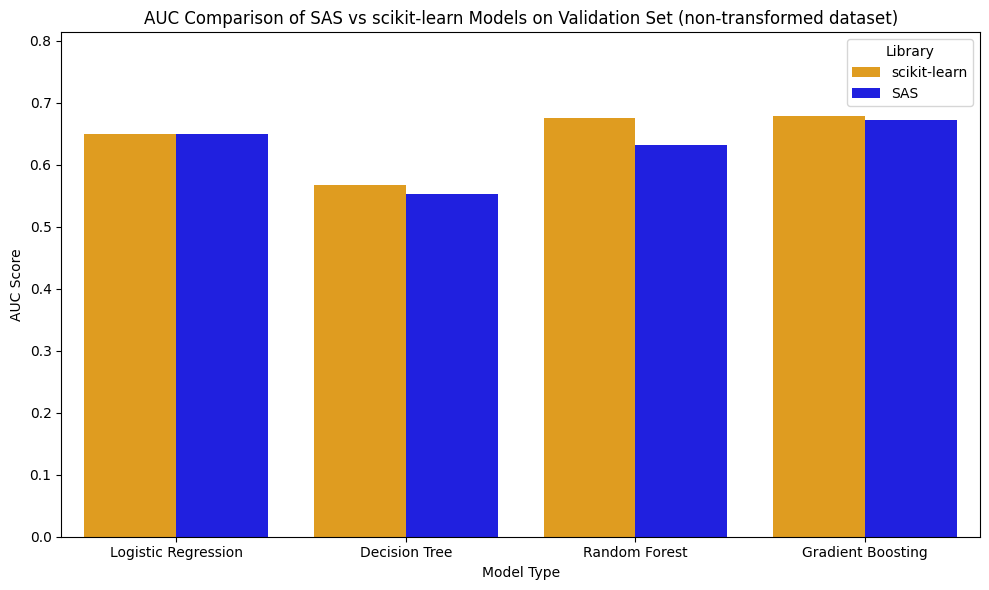

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
colors = {"SAS": "blue", "scikit-learn": "orange"}
ax = sns.barplot(
    data=metrics_df, 
    x="Model Type", 
    y="AUC_val", 
    hue="Library", 
    palette=colors
)
plt.title("AUC Comparison of SAS vs scikit-learn Models on Validation Set (non-transformed dataset)")
plt.ylabel("AUC Score")
plt.xlabel("Model Type")
plt.legend(title="Library")
ax.set_ylim(0, metrics_df["AUC_val"].max() * 1.2)
plt.tight_layout()
plt.show()

#### Hyperparameter tuning and Model Selection

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

objective = Objective(X_train, y_train, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-12-12 16:22:23,933] A new study created in memory with name: no-name-171c9cd6-c73b-45e9-b7f1-54a5028c917c
[I 2024-12-12 16:22:24,579] Trial 0 finished with value: 0.5913343551678246 and parameters: {'classifier': 'dtree', 'library': 'sklearn', 'resampling': False, 'dtree_max_depth': 13, 'dtree_min_samples_leaf': 19}. Best is trial 0 with value: 0.5913343551678246.
[I 2024-12-12 16:22:27,604] Trial 1 finished with value: 0.6783374839707422 and parameters: {'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 41, 'gb_max_depth': 6, 'gb_min_samples_leaf': 11, 'gb_n_bins': 24, 'gb_subsample': 0.5156294197642088, 'gb_learning_rate': 0.1}. Best is trial 1 with value: 0.6783374839707422.
[I 2024-12-12 16:22:28,668] Trial 2 finished with value: 0.662187110690196 and parameters: {'classifier': 'rf', 'library': 'sklearn', 'resampling': True, 'sampling_strategy': 0.2980504783008378, 'rf_n_estimators': 80, 'rf_max_depth': 12, 'rf_min_samples_leaf': 24, 'rf_max_

In [14]:
# Define a function to create and train a pipeline with the best parameters
def train_best_pipeline(X, y, best_params, preprocessor):
    classifiers = {
        "sasviya": {"rf": create_sas_rf,
                    "dtree": create_sas_dtree,
                    "gb": create_sas_gb},
        "sklearn": {"rf": create_sklearn_rf,
                    "dtree": create_sklearn_dtree,
                    "gb": create_sklearn_gb},
    }

    # Extract the best parameters
    classifier_name = best_params["classifier"]
    library_name = best_params["library"]
    resampling = best_params["resampling"]

    # Create the classifier using the best parameters
    library_classifiers = classifiers[library_name]
    if classifier_name in library_classifiers:
        classifier_obj = library_classifiers[classifier_name](optuna.trial.FixedTrial(best_params))
    else:
        raise ValueError(f"Unsupported classifier: {classifier_name}")

    # Create the pipeline steps
    pipeline_steps = []
    pipeline_steps.append(('imputer', MissingValueImputer()))
    pipeline_steps.append(('cat_filter', CategoricalLevelFilter()))

    if library_name == "sklearn":
        pipeline_steps.append(('preprocessor', preprocessor))

    pipeline_steps.append(('model', classifier_obj))
    
    pipeline = Pipeline(pipeline_steps)

    if resampling:
        sampling_strategy = best_params["sampling_strategy"]
        rus = RandomUnderSampler(random_state=12345, sampling_strategy=sampling_strategy)
        X, y = rus.fit_resample(X, y)
    
    # Train the pipeline on the entire training set
    if library_name == "sasviya":
        cat_cols = X.select_dtypes(exclude='number').columns
        pipeline.fit(X, y, model__nominals=cat_cols)
    elif library_name == "sklearn":
        pipeline.fit(X, y)

    return pipeline

In [15]:
print("Set of best parameters:")
print(study.best_params)

Set of best parameters:
{'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 41, 'gb_max_depth': 6, 'gb_min_samples_leaf': 11, 'gb_n_bins': 24, 'gb_subsample': 0.5156294197642088, 'gb_learning_rate': 0.1}


In [16]:
best_parameters = study.best_params
best_pipeline = train_best_pipeline(X_train, y_train, best_parameters, preprocessor)

In [17]:
# AUC score on test set
cat_levels = best_pipeline.named_steps['cat_filter'].levels
valid_rows_mask = X_test[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
y_test = y_test[valid_rows_mask]

# Compute AUC scores
auc_train, auc_test = compute_auc(best_pipeline, X_train, y_train, X_test, y_test)
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the test set: 0.71


### Model Building for transformed dataset

In [18]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data.csv")
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13052 (90.34 %)
- Number of rows with churn='Yes': 1395 (9.66 %)


In [19]:
sas_lr = SASLogisticRegression()
sklearn_lr = SKLogisticRegression(solver='liblinear')
sas_dtree = SASDecisionTreeClassifier()
sklearn_dtree = SKDecisionTreeClassifier()
sas_rf = SASForestClassifier()
sklearn_rf = SKRandomForestClassifier()
sas_gb = SASGradientBoostingClassifier()
sklearn_gb = SKGradientBoostingClassifier()

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

sklearn_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_lr)
])

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_dtree)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_rf)
])

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_gb)
])

In [20]:
# sas_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sas_lr, 'Logistic Regression', 'SAS', k=k, sampling_strategy=sampling_strategy, numeric_cols=numeric_cols, nominals=cat_cols)
# sklearn_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sklearn_lr_pipeline, 'Logistic Regression', 'scikit-learn', k=k, sampling_strategy=sampling_strategy, numeric_cols=numeric_cols)
# sklearn_dtree_metrics = train_and_evaluate_model(X_train, y_train, dtree_pipeline, 'Decision Tree', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
# sas_dtree_metrics = train_and_evaluate_model(X_train, y_train, sas_dtree, 'Decision Tree', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)
# sklearn_rf_metrics = train_and_evaluate_model(X_train, y_train, rf_pipeline, 'Random Forest', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
# sas_rf_metrics = train_and_evaluate_model(X_train, y_train, sas_rf, 'Random Forest', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)
# sklearn_gb_metrics = train_and_evaluate_model(X_train, y_train, gb_pipeline, 'Gradient Boosting', 'scikit-learn', k=k, sampling_strategy=sampling_strategy)
# sas_gb_metrics = train_and_evaluate_model(X_train, y_train, sas_gb, 'Gradient Boosting', 'SAS', k=k, sampling_strategy=sampling_strategy, nominals=cat_cols)

# tfm_metrics_df = sklearn_lr_model_metrics
# tfm_metrics_df = pd.concat([tfm_metrics_df, sas_lr_model_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_dtree_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sas_dtree_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_rf_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sas_rf_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_gb_metrics], ignore_index=True)
# tfm_metrics_df = pd.concat([tfm_metrics_df, sas_gb_metrics], ignore_index=True)
# tfm_metrics_df

NameError: name 'tfm_metrics_df' is not defined

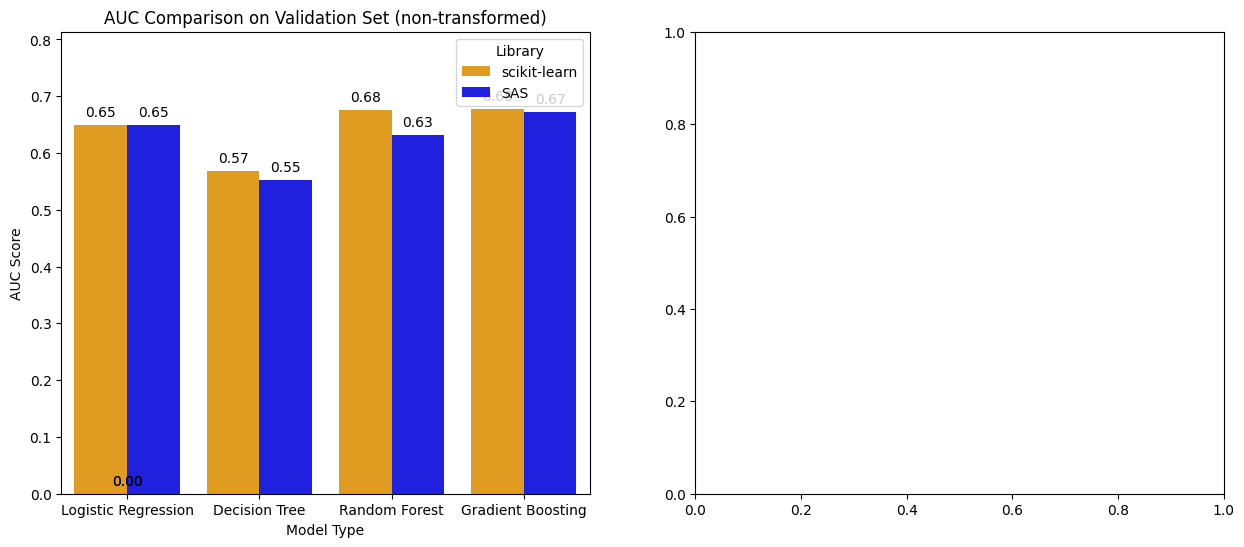

In [21]:
# Define color palette
colors = {"SAS": "blue", "scikit-learn": "orange"}

# Function to add labels to bars
def add_labels(ax):
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.01, 
                f"{p.get_height():.2f}", ha='center', va='bottom', fontsize=10)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for non-transformed dataset
sns.barplot(data=metrics_df, x="Model Type", y="AUC_val", hue="Library", palette=colors, ax=axes[0])
axes[0].set(title="AUC Comparison on Validation Set (non-transformed)", ylabel="AUC Score", xlabel="Model Type")
axes[0].set_ylim(0, metrics_df["AUC_val"].max() * 1.2)
add_labels(axes[0])

# Plot for transformed dataset
sns.barplot(data=tfm_metrics_df, x="Model Type", y="AUC_val", hue="Library", palette=colors, ax=axes[1])
axes[1].set(title="AUC Comparison (transformed)", ylabel="AUC Score", xlabel="Model Type")
axes[1].set_ylim(0, tfm_metrics_df["AUC_val"].max() * 1.2)
add_labels(axes[1])

# Adjust layout and display
plt.tight_layout()
plt.show()

In this case as well, we observe overfitting in the tree models. Furthermore, there doesn't appear to be a significant improvement in the AUC score compared to the non-transformed dataset. Nonetheless, we will proceed with hyperparameter tuning and ultimately select the best model, either from the non-transformed or transformed dataset, based on their test set performance.

In [ ]:
# Define hyperparameter search space for each model
# def create_lr(trial):
#     lr_class_weight = trial.suggest_categorical("lr_class_weight", [None, "balanced"])
#     lr_c = trial.suggest_float("lr_c", 1e-2, 1e2, log=True)
#     return LogisticRegression(C=lr_c,
#                               class_weight=lr_class_weight)

# def create_svc(trial):
#     svc_class_weight = trial.suggest_categorical("svc_class_weight", [None, "balanced"])
#     svc_c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)
#     svc_kernel = trial.suggest_categorical("svc_kernel", ["poly", "rbf", "sigmoid", "linear"])
#     return SVC(C=svc_c,
#                kernel=svc_kernel,
#                class_weight=svc_class_weight)

# def get_best_pipeline(parameters):
    
#     if parameters["classifier"] == "dtree":
#         model = LogisticRegression(C=parameters["lr_c"],
#                                    class_weight=parameters["lr_class_weight"])
#     elif parameters["classifier"] == "rf":
#         if parameters["nb_classifier_type"] == "multinomial":
#             model = MultinomialNB(alpha=parameters["nb_alpha"])
#         else:
#             model = ComplementNB(alpha=parameters["nb_alpha"])
#     elif parameters["classifier"] == "gb":
#         model = SVC(
#             C=parameters["svc_c"],
#             kernel=parameters["svc_kernel"],
#             class_weight=parameters["svc_class_weight"]
#         )
        
#     return Pipeline([
#         ('tfidf', tfidf_vectorizer),
#         ('model', model)
#     ])

In [22]:
import optuna

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

objective = Objective(X_train, y_train, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-12-12 16:35:46,054] A new study created in memory with name: no-name-72c1513a-2576-425e-806e-1ca2c9a64fe6
[I 2024-12-12 16:36:09,891] Trial 0 finished with value: 0.6648128061737125 and parameters: {'classifier': 'gb', 'library': 'sasviya', 'resampling': True, 'sampling_strategy': 0.1834271317170718, 'gb_n_estimators': 78, 'gb_max_depth': 4, 'gb_min_samples_leaf': 29, 'gb_n_bins': 28, 'gb_subsample': 0.5207951883265971, 'gb_learning_rate': 0.1}. Best is trial 0 with value: 0.6648128061737125.
[I 2024-12-12 16:36:49,256] Trial 1 finished with value: 0.6485104220120709 and parameters: {'classifier': 'gb', 'library': 'sklearn', 'resampling': False, 'gb_n_estimators': 93, 'gb_max_depth': 10, 'gb_min_samples_leaf': 11, 'gb_n_bins': 39, 'gb_subsample': 0.5499114267718384, 'gb_learning_rate': 0.1}. Best is trial 0 with value: 0.6648128061737125.
[I 2024-12-12 16:37:04,982] Trial 2 finished with value: 0.5924591225891144 and parameters: {'classifier': 'dtree', 'library': 'sasviya', 're

In [23]:
print("Set of best parameters:")
print(study.best_params)

Set of best parameters:
{'classifier': 'gb', 'library': 'sasviya', 'resampling': True, 'sampling_strategy': 0.1834271317170718, 'gb_n_estimators': 78, 'gb_max_depth': 4, 'gb_min_samples_leaf': 29, 'gb_n_bins': 28, 'gb_subsample': 0.5207951883265971, 'gb_learning_rate': 0.1}


In [25]:
best_parameters = study.best_params
best_pipeline = train_best_pipeline(X_train, y_train, best_parameters, preprocessor)

In [26]:
# AUC score on test set
cat_levels = best_pipeline.named_steps['cat_filter'].levels
valid_rows_mask = X_test[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
y_test = y_test[valid_rows_mask]

# Compute AUC scores
auc_train, auc_test = compute_auc(best_pipeline, X_train, y_train, X_test, y_test)
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the test set: 0.71


### Cutoff optimization

The SAS Gradient Boosting model is the one performing better on test data. Therefore, this is the model we'll choose for identifying churners among our customer base to take action and try to keep them. Let's assume that to prevent a client from churning, PowerCo issues a 10% discount on their electricity price. We also assume that this definitively deters the client from churning.

Even though PowerCo doesn't want either to lose a client and is ready to give it a discount, they don't want to hand out free discounts and offer it also to customers who would stay anyway. Keeping that in mind, let's now identify the churn probability threshold that enables us to optimize the overall profit for PowerCo.

To this aim, we can compute for different probability thresholds the profit function as:
$$
\text{Profit}(p)=\text{Gains}-\text{Loss}+\text{Prevented Loss}-\text{Discount Loss}
$$
where:
- **Gains** is the sum of all margins, contained in net_margin_ele variable
- **Loss** is the sum of all margins of actual churners
- **Prevented Loss** is the sum of all margins of actual churners that are correctly predicted as churners by the model with threshold $p$
- **Discount Loss** is the sum of discounts given to all predicted churners (whether correctly or incorrectly predicted). In our example, we might assume that the discount is operated on the net margin (that is only a component of the total tariff), to make computations easier, but it should be actually properly defined what a 10% tariff discount means.

Then, choose the threshold $p^*$ leading to the highest profit, given by $Profit(p^*)$.
We can compare this situation with what would’ve happened if we didn’t do anything:
$$
\text{Profit}=\text{Gains}-\text{Loss}
$$
to compute the financial impact of our model (percent improvement in profit).

The discount is an hyperparameter of the model, in a sense, that can be tuned based on how much increase in profit you want to achieve and/or on the average current competitor price for the customer we are considering. For example, based on postal code and number of kWh consumed, the average competitor price can change, and then considering the percent difference between LichtBlick tariff and average tariff can help us choose the discount needed in order for it to be effective.

In [27]:
import matplotlib.pyplot as plt

def test_model(y, preds, margins, event_value='Yes', discount_rate=0.1, discount_efficiency=0.8):
    """Test a model by calculating the margin saved when applying a discount,
    taking into account discounts wrongly applied to non-churning clients. """
    def find_best_p(preds, discount, discount_efficiency, granularity=200):
        """Optimization function to find the best probability cutoff"""
        probas = np.linspace(0, 1, granularity)
        output_margins = np.zeros(len(probas))
        actual_churners = (y == event_value)

        gains = np.sum(margins)*1000
        loss = sum(margins[actual_churners])*1000

        for i, p in enumerate(probas):
            predicted_churners = preds>=p
            prevented_loss = sum(margins[predicted_churners & actual_churners])*1000*discount_efficiency
            # To make calculations easier, we assume that the discount
            # is operated on the net margin. It could actually be a bit more.
            discount_loss = sum(margins[predicted_churners])*discount*1000
            output_margins[i] = gains - loss + prevented_loss - discount_loss

        best_profit = max(output_margins)
        best_p_index = list(output_margins).index(best_profit)
        best_p = probas[best_p_index]
        worst_profit = gains - loss
        return probas, output_margins, best_p, best_profit, worst_profit
    
    # Find optimal cutoff and margins
    probas, output_margins, best_p, best_profit, worst_profit = find_best_p(preds, discount_rate, discount_efficiency, 200)
    
    # Calculate additional metrics
    num_customers_best_p = np.sum(preds >= best_p)
    total_customers = len(y)
    
    print('Above a', round(best_p, 4), 'predicted probability of churn, we should apply the', discount_rate * 100, '% discount to the client.')
    print("By doing so, PowerCo would make {} € more in annual profit ({}% more than without the model).".format(
        round(best_profit - worst_profit, 2), 
        round(100 * (best_profit - worst_profit) / worst_profit, 2)))
    print(f"""{num_customers_best_p} out of {total_customers} customers ({round(100 * num_customers_best_p / total_customers, 2)}%) """
          f"""would receive the discount and we are assuming a {discount_efficiency*100} % efficiency of the retention campaign.""")
    
    plt.plot(probas, output_margins)
    plt.xlabel("Probability cutoff")
    plt.ylabel("Annual Profit")
    plt.axvline(x=best_p, color='red')
    plt.show()

Regarding the annual profit, we will use the `margin_net_pow_ele_log` variable. However, we need to retrieve the original values, which can be obtained by applying the inverse transformation of $log(1+x)$, i.e. $x=exp(y)-1$.

Above a 0.1759 predicted probability of churn, we should apply the 10.0 % discount to the client.
By doing so, PowerCo would make 2043224.0 € more in annual profit (3.3% more than without the model).
840 out of 2890 customers (29.07%) would receive the discount and we are assuming a 80.0 % efficiency of the retention campaign.


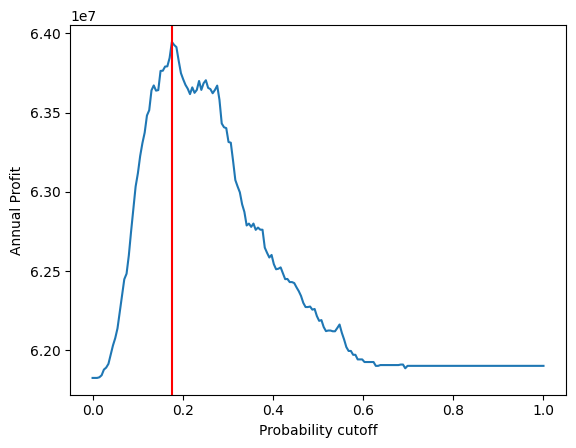

In [30]:
margins = np.expm1(X_test.iloc[:,list(X_test.columns).index('margin_net_pow_ele_log')])

y_pred_proba = best_pipeline.predict_proba(X_test).iloc[:,1]
test_model(y_test, y_pred_proba, margins, discount_rate=0.1, discount_efficiency=0.8)

### Next Steps

- Both when predicting a customer's churn likelihood and when determining the discount to offer a potential churner, considering **competitor tariffs** could be valuable. 
This can be achieved by introducing a new variable, such as `competitor_avg_tariff_lastmonth`, which represents the average tariff for the last month of the historical data period. This value can be calculated using data from sources like CHECK24, taking into account the *postal code* and the *number of kilowatt-hours consumed* (based on actual or estimated readings). These two inputs are essential for CHECK24's tariff comparisons, helping users identify the most competitive offers.
- An additional step that could enhance the analysis is performing **customer segmentation** prior to training the churn model. By using clustering techniques, we could train separate churn models for each customer segment, allowing us to better understand the distinct patterns within different types of customers. This approach was not implemented in this project due to the limited data available for training, but it could provide valuable insights and improve the model's performance in the future.

### Conclusions

To wrap up, in this project we performed churn prediction for an energy company using data from the `'client_data_raw.csv'` and `'price_data_raw.csv'` files. The workflow was divided into three main parts:

- **Data Quality and Preprocessing** (`'Churn Prediction - Part 1'`):
    - We began by inspecting variable types and performing data quality checks.
    - Inconsistent rows were identified, removed, and saved to CSV files for further investigation with the data provider.
- **Feature Engineering and Data Transformation** (`'Churn Prediction - Part 2'`):
    - We summarized the price values for each customer ID and merged the datasets.
    - Several feature engineering and data transformation steps were implemented to prepare the data for modeling.
- **Model Building and Evaluation** (`'Churn Prediction - Part 3'`):
    - We trained and compared multiple machine learning models using both scikit-learn and SAS via the **Python API in SAS Viya Workbench**.
    - Model performance was evaluated using cross-validated AUC scores.
    - After selecting the best-performing model, we retrained it on the entire training set.
    - We determined the optimal probability cutoff that maximized company profit, simulating a retention campaign in which discounts were offered to customers predicted as likely churners. The cutoff optimization was customized based on assumed retention efficiency and discount rates.

By following this structured approach, we provided a comprehensive framework for churn prediction, enabling the energy company to enhance its retention strategies, minimize customer loss, and maximize its profit effectively.

### TO DO
- Add SVC (both SAS and scikit-learn).
- Add 'Undersampling' column in metrics dataframe, which can be equal to 'No', or two values, like 20% of the total or 30% of the total.
- Model Interpretability section!